# Домашняя работа №4

## Задание
- обучить сверточную нейронную сеть в стиле AlexNet (с падением размера ядра свертки и последовательностью блоков свертка-пулинг  (conv-pool)-(conv-pool)-...) на датасете fashion-mnist или cifar10
- оценить рост точности при увеличении ширины сети (больше ядер)
- оценить рост точности при увеличении глубины сети (больше слоев)

In [18]:
from __future__ import print_function
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
#import tensorflow.keras as keras # расскоментируйте эту строку, чтобы начать обучение
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
import os

In [19]:

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16646280788217724979
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14465892352
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15362086622686165416
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]
Num GPUs Available:  1


In [20]:
classes=['самолет', 'автомобиль', 'птица', 'кот', 'олень', 'собака', 'лягушка', 'лошадь', 'корабль', 'грузовик']

In [25]:
# установка параметров нейросети
batch_size = 32
num_classes = 10
epochs = 1
data_augmentation = True
num_predictions = 20
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_cifar10_trained_model.h5'

# разделение тренировочной и тестовой выборки
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'тренировочные примеры')
print(x_test.shape[0], 'тестовые примеры')

# преобразование матрицы чисел 0-9 в бинарную матрицу чисел 0-1
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

x_train shape: (50000, 32, 32, 3)
50000 тренировочные примеры
10000 тестовые примеры


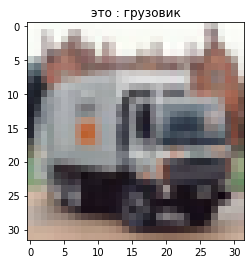

In [26]:
N = 11

plt.imshow(x_test[N][:,:,:])
plt.title('это : '+classes[np.argmax(y_test[N,:])])
plt.show()

#### Напишем функцию автоматизирующую обучение

In [42]:
def fit_predict(model, data_augmentation):
    """Обучает модель"""
    if not data_augmentation:
        print('Не используется data augmentation')
        model.fit(x_train, y_train,
                  batch_size=batch_size,
                  epochs=epochs,
                  validation_data=(x_test, y_test),
                  shuffle=True)
    else:
        print('Использование data augmentation в реальном времени')
        # Препроцессинг и data augmentation в реальном времени:
        datagen = ImageDataGenerator(featurewise_center=False,
                                     samplewise_center=False,
                                     featurewise_std_normalization=False,
                                     samplewise_std_normalization=False,
                                     zca_whitening=False, 
                                     zca_epsilon=1e-06, 
                                     rotation_range=5, 
                                     width_shift_range=0.1,
                                     height_shift_range=0.1,
                                     shear_range=0., 
                                     zoom_range=0., 
                                     channel_shift_range=0.,
                                     fill_mode='nearest',
                                     cval=0.,
                                     horizontal_flip=True,
                                     vertical_flip=False,
                                     rescale=None,
                                     preprocessing_function=None,
                                     data_format=None,
                                     validation_split=0.0)
        # запуск data augmentation через fit
        #datagen.fit(x_train)
        # запуск data augmentation через fit_generator
        model.fit(datagen.flow(x_train, y_train,
                               batch_size=batch_size),
                  epochs=epochs,
                  validation_data=(x_test, y_test),
                  workers=-1)
    accuracy = model.history.history['accuracy']
    loss = model.history.history['loss']
    val_accuracy = model.history.history['val_accuracy']
    val_loss = model.history.history['val_loss']
    return accuracy, loss, val_accuracy, val_loss

#### Построим базовую сеть

In [135]:
# конфигурирование слоев нейросети
model = Sequential()

# слои нейросети отвественные за свертку и max-pooling
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout( 0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# полносвязные слои нейронной сети
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))


# компиляция модели
model.compile(loss='categorical_crossentropy',
              optimizer='SGD',
              metrics=['accuracy'])

train_accuracy, train_loss, val_accuracy, val_loss = fit_predict(model, data_augmentation=False)

# проверка работы обученной модели
scores = model.evaluate(x_test, y_test, verbose=1)
test_loss, test_accuracy = scores[0], scores[1]
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)

Не используется data augmentation
313/313 [==============================] - 1s 4ms/step - loss: 1.8920 - accuracy: 0.3374
Test loss: 1.8919570446014404
Test accuracy: 0.33739998936653137


## Увеличим кол-во ядер

In [152]:
# конфигурирование слоев нейросети
model = Sequential()

# слои нейросети отвественные за свертку и max-pooling
model.add(Conv2D(32, (5, 5), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (5, 5)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout( 0.25))

model.add(Conv2D(64, (5, 5), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (5, 5)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))


# полносвязные слои нейронной сети
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# компиляция модели
model.compile(loss='categorical_crossentropy',
              optimizer='SGD',
              metrics=['accuracy'])

In [153]:
model.summary()

Model: "sequential_53"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_240 (Conv2D)         (None, 32, 32, 32)        2432      
                                                                 
 activation_342 (Activation)  (None, 32, 32, 32)       0         
                                                                 
 conv2d_241 (Conv2D)         (None, 28, 28, 32)        25632     
                                                                 
 activation_343 (Activation)  (None, 28, 28, 32)       0         
                                                                 
 max_pooling2d_119 (MaxPooli  (None, 14, 14, 32)       0         
 ng2D)                                                           
                                                                 
 dropout_168 (Dropout)       (None, 14, 14, 32)        0         
                                                     

In [154]:
train_accuracy, train_loss, val_accuracy, val_loss = fit_predict(model, data_augmentation=False)
# проверка работы обученной модели
scores = model.evaluate(x_test, y_test, verbose=1)
test_loss, test_accuracy = scores[0], scores[1]
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)

Не используется data augmentation
313/313 [==============================] - 2s 5ms/step - loss: 1.7133 - accuracy: 0.3814
Test loss: 1.713327169418335
Test accuracy: 0.3813999891281128


**После увеличения ядра точность увеличилась**

#### Добавим слои к первоначалной конфигурации

In [161]:
# конфигурирование слоев нейросети
model = Sequential()

# слои нейросети отвественные за свертку и max-pooling
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout( 0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# полносвязные слои нейронной сети
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))


# компиляция модели
model.compile(loss='categorical_crossentropy',
              optimizer='SGD',
              metrics=['accuracy'])

In [162]:
model.summary()

Model: "sequential_56"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_255 (Conv2D)         (None, 32, 32, 32)        896       
                                                                 
 activation_363 (Activation)  (None, 32, 32, 32)       0         
                                                                 
 conv2d_256 (Conv2D)         (None, 30, 30, 32)        9248      
                                                                 
 activation_364 (Activation)  (None, 30, 30, 32)       0         
                                                                 
 max_pooling2d_127 (MaxPooli  (None, 15, 15, 32)       0         
 ng2D)                                                           
                                                                 
 dropout_179 (Dropout)       (None, 15, 15, 32)        0         
                                                     

In [163]:
train_accuracy, train_loss, val_accuracy, val_loss = fit_predict(model, data_augmentation=False)

# проверка работы обученной модели
scores = model.evaluate(x_test, y_test, verbose=1)
test_loss, test_accuracy = scores[0], scores[1]
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)

Не используется data augmentation
313/313 [==============================] - 1s 3ms/step - loss: 2.1453 - accuracy: 0.1936
Test loss: 2.145282506942749
Test accuracy: 0.19359999895095825


**При добавлении слоев точность уменьшилась**